# Setup

In [1]:
import numpy as np
import scipy
import wavio
from tqdm import tqdm
import os
import shutil
import IPython.display as ipd

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.dpi'] = 300

from matplotlib.collections import LineCollection
from mpl_toolkits.mplot3d.art3d import Line3DCollection
from matplotlib.collections import PolyCollection
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patheffects as path_effects


import time

In [2]:
def sinusoid(frequency, T, p = 0, SR = 48000, dtype = 'float'):
    phase = 2 * np.pi * (frequency * np.arange(0, T, 1 / SR) - p)
    if dtype == 'complex':
        return np.exp(1j * phase)
    return np.sin(phase)

def square(frequency, T, p = 0, SR = 48000):
    return sum(sinusoid(frequency * n, T, p, SR) / n for n in range(1, SR // (2 * frequency), 2))

def saw(frequency, T, p = 0.5, SR = 48000):
    return sum(sinusoid(frequency * n, T, p, SR) / n for n in range(1, SR // (2 * frequency)))

def tri(frequency, T, p = 0, SR = 48000):
    return 

def analyze(x, delays, k, oversample = 1, alpha = 0.9, epsilon = 0.0001, delta = 0.01, gamma = 0.01, dtype = 'float', randomize = True, track = False):
    N = len(delays)
    x = x.astype(dtype)
    # ds = np.cumsum(delays)
    ds = np.array(delays)
    X = np.append(np.zeros(ds[-1], dtype = dtype), x)
    
    A = np.eye(N,k, dtype = dtype)
    Y = np.random.random((N,N)) + (1j if dtype == 'complex' else 0) * np.random.random((N, N))
    Y = Y - np.conj(Y.T)
    if randomize:
        A = scipy.linalg.expm(Y) @ A
    
    B = np.zeros((N,N), dtype = dtype)
    
    trajectory = np.zeros((len(x), k), dtype = dtype)
    bases = np.zeros((len(x), N, k), dtype = dtype)
    distances = np.zeros(len(x))
    
    try:
        for i in (tqdm(range(ds[-1], len(X))) if track else range(ds[-1], len(X))):
            y = X[i - ds]
            B = alpha * B + np.outer(y,y) / (gamma + y @ y)
            for j in range(oversample):
                C = B @ A
                A += epsilon * np.sqrt(N * k) * (C - A @ (np.conj(A.T) @ C))
                A += delta * np.sqrt(N * k) * A @ (np.eye(k) - np.conj(A.T) @ A)
            trajectory[i - ds[-1]] = np.conj(A.T) @ y
            bases[i - ds[-1]] = A
            distances[i - ds[-1]] = (y @ y - trajectory[i - ds[-1]] @ trajectory[i - ds[-1]]) / (gamma + y @ y)
    except KeyboardInterrupt:
        return trajectory[:i-ds[-1]], bases[:i-ds[-1]], distances[:i-ds[-1]]
    
    return trajectory, bases, distances

# Visualization

In [3]:
SR = 48000
T = 3
d = np.array([0, SR // 60])
T = 1
fm = 60

# fs = [110, 115, 120, 125, 130]
fs = [100, 110, 120, 130, 140]
sinusoids = [sinusoid(f, T) for f in fs]
squares = [square(f, T) for f in fs]
saws = [saw(f, T) for f in fs]

harms = 7
sinstacks = [sum(sinusoid(n * f, T) / n ** 2 for n in range(1, harms+1)) for f in fs]
squarestacks = [sum(square(n * f, T) / n ** 2 for n in range(1, harms+1)) for f in fs]
sawstacks = [sum(saw(n * f, T) / n ** 2 for n in range(1, harms+1)) for f in fs]

collections = [sinusoids, squares, saws, sinstacks, squarestacks, sawstacks]

for collection in collections:
    for i in range(len(fs)):
        collection[i] /= np.max(np.abs(collection[i]))

In [4]:
def timbre_vs_frequency(collections, d, name):
    color = plt.cm.rainbow(np.linspace(0, 1, len(d)))
    fig, ax = plt.subplots(nrows = len(collections[0]), ncols = len(collections))
    for i, collection in enumerate(tqdm(collections)):
        for j, s in enumerate(collection):
            a = ax[j,i]
            a.set_xlim([-np.sqrt(len(d)),np.sqrt(len(d))])
            a.set_ylim([-np.sqrt(len(d)),np.sqrt(len(d))])
            a.set_aspect('equal')
            a.set_axis_off()

            trajectory, bases, distances = analyze(s, d, 2, randomize = False)

            K = SR // fm
            segments = np.zeros((K - 1, 2, 2))
            segments[:,0] = trajectory[-K:-1]
            segments[:,1] = trajectory[-K+1:]

            distances = distances[-K:]
            darknesses = 0.5 * (1 - distances)
            colors = np.zeros((K - 1, 4))
            for l, _ in enumerate(colors):
                colors[l] = (darknesses[l], darknesses[l], darknesses[l], 1)

            lc = LineCollection(segments, color = colors, linewidth = 1, path_effects=[path_effects.Stroke(capstyle="round")])
            a.add_collection(lc)

            # a.plot(*trajectory[-K:].T, linewidth = 1)
            if (len(d) > 2):
                for n, c in zip(range(len(d)), color):
                    a.plot(*(0.75 * np.sqrt(len(d)) * bases[-K:, n].T), c = c, linewidth = 2, alpha = 0.75, solid_capstyle='round')
                
    plt.savefig(f'Fig/{name}.pdf', bbox_inches='tight')  

100%|█████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:01<00:00, 10.17s/it]


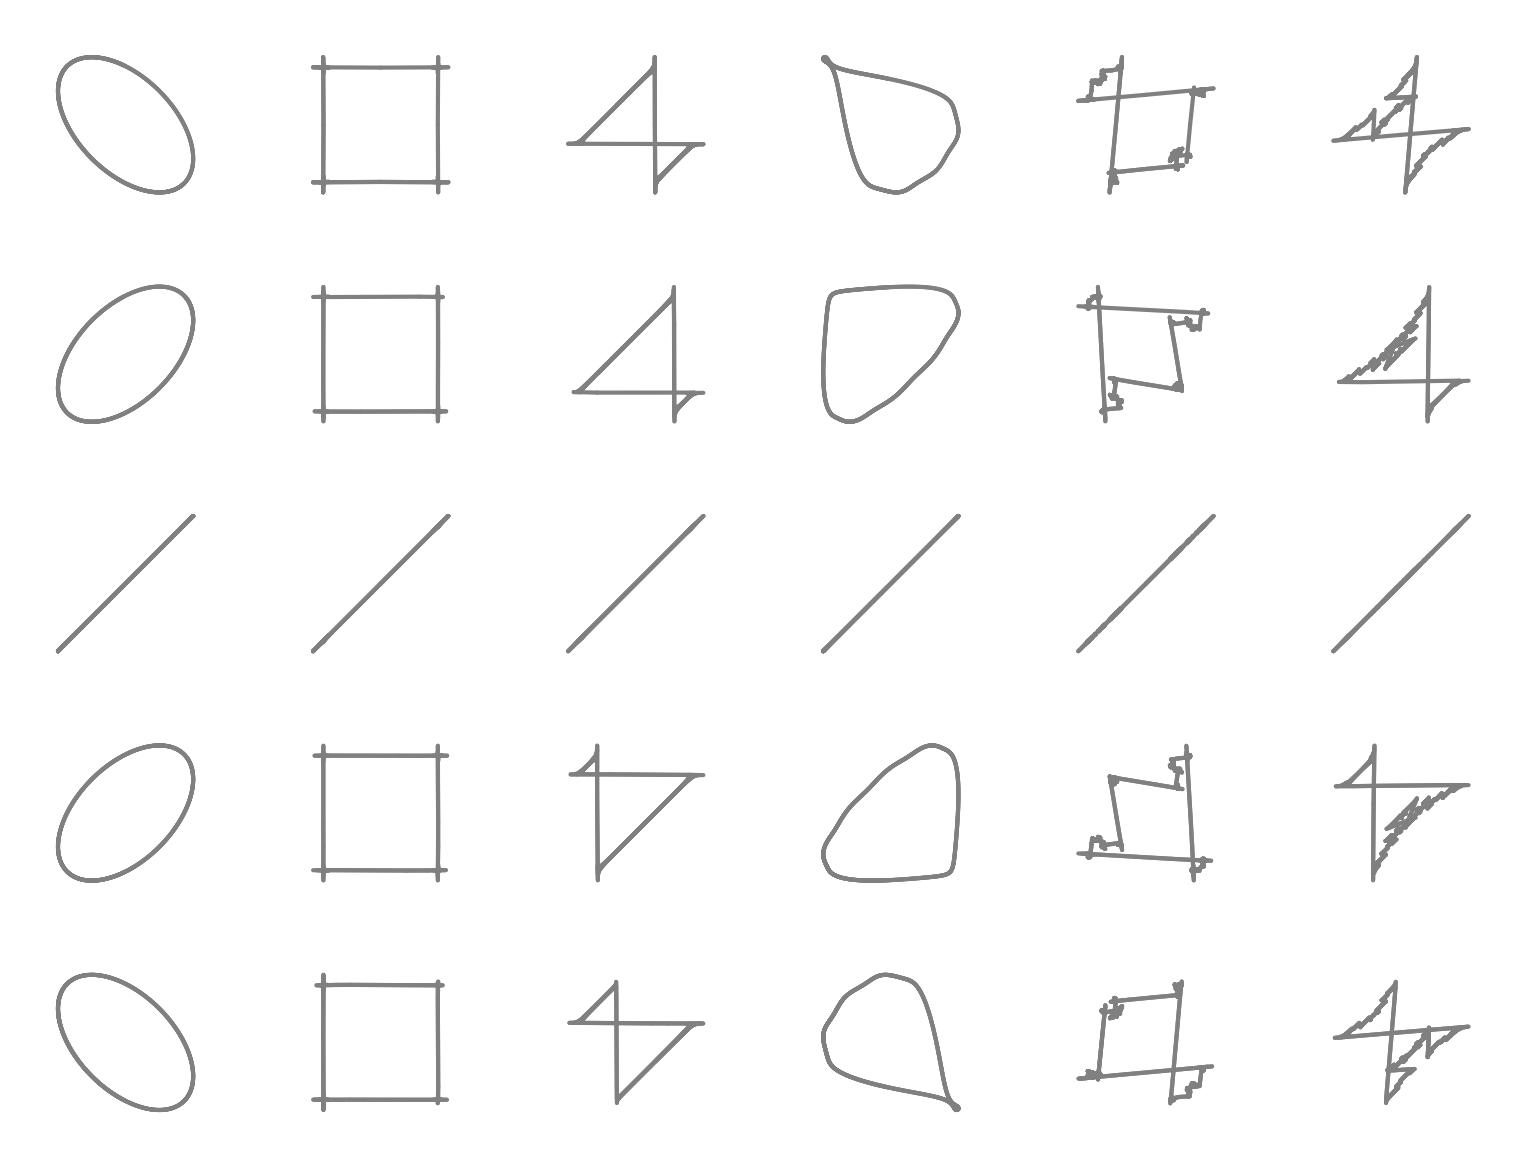

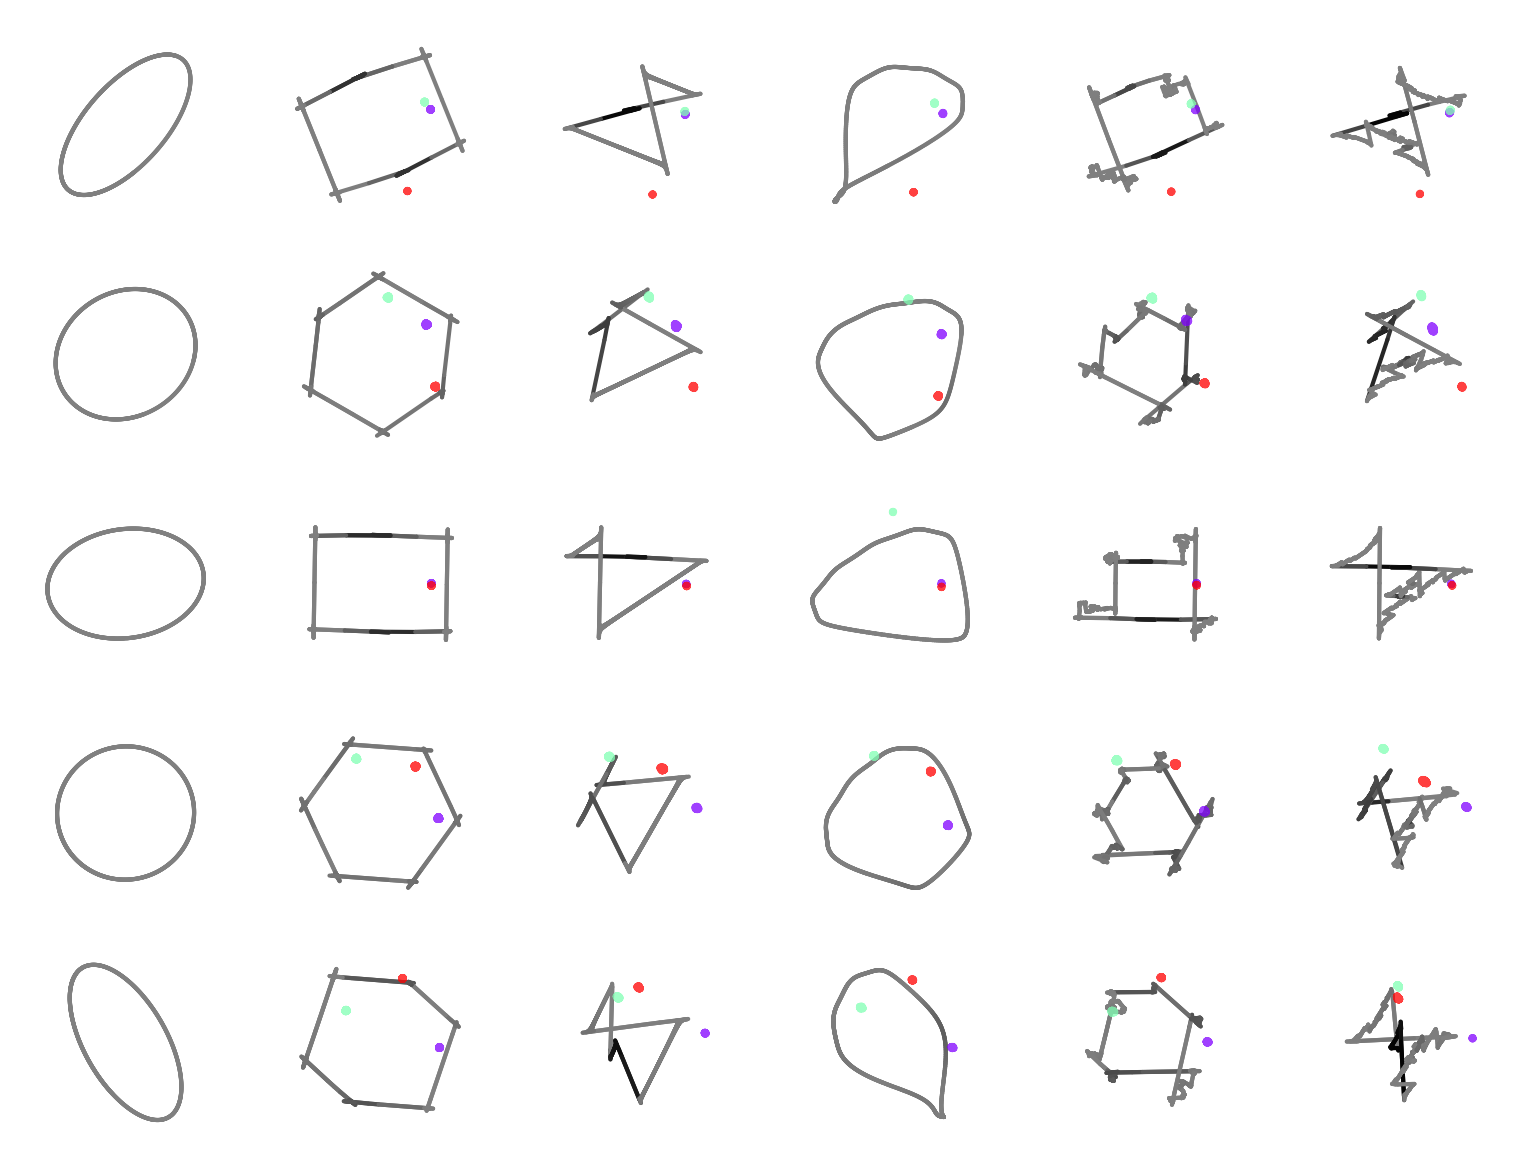

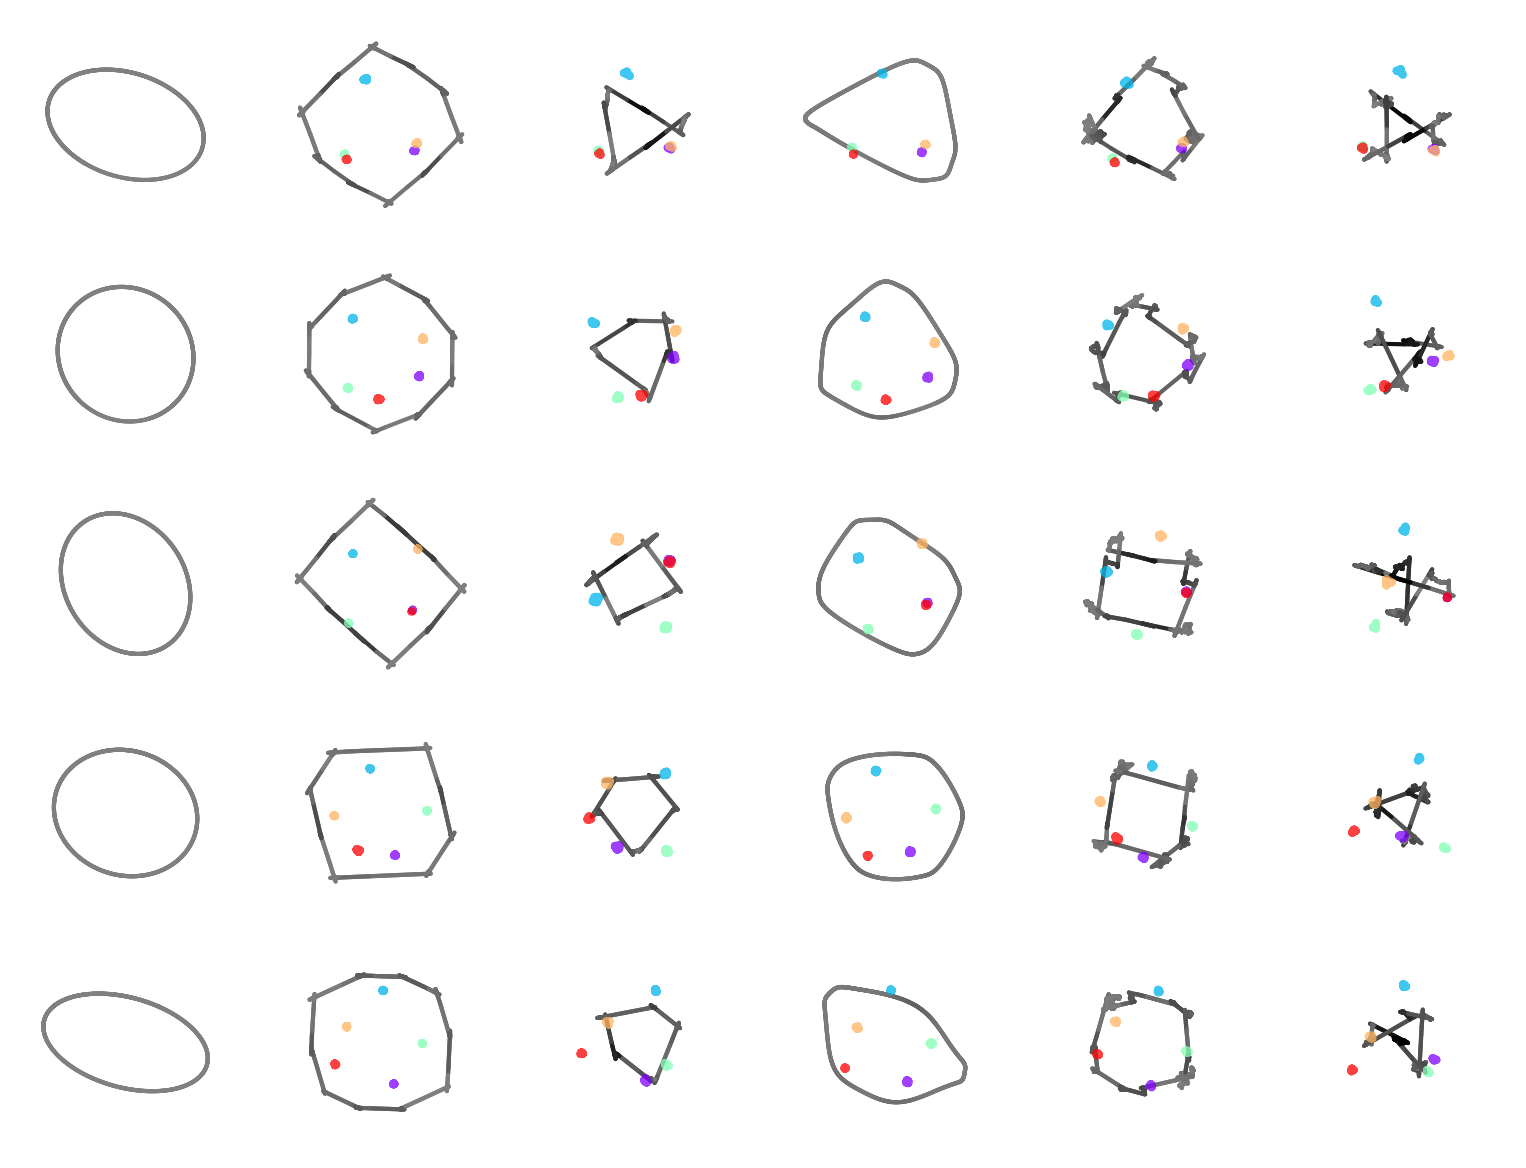

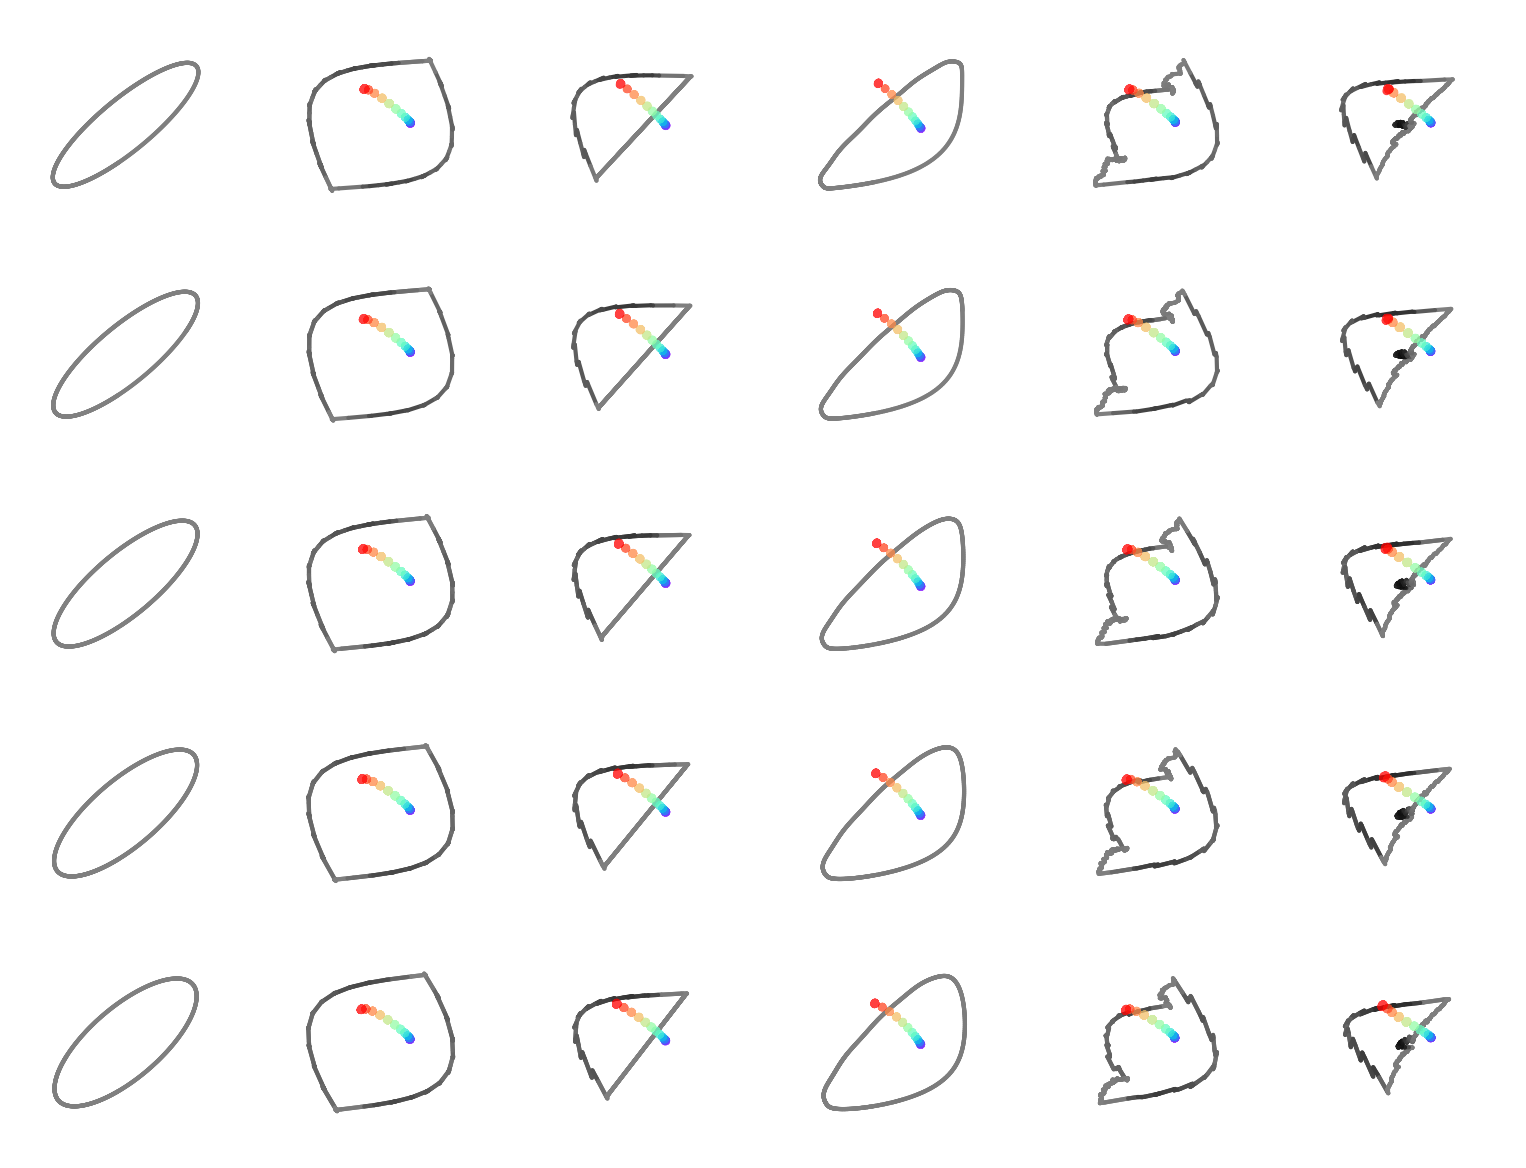

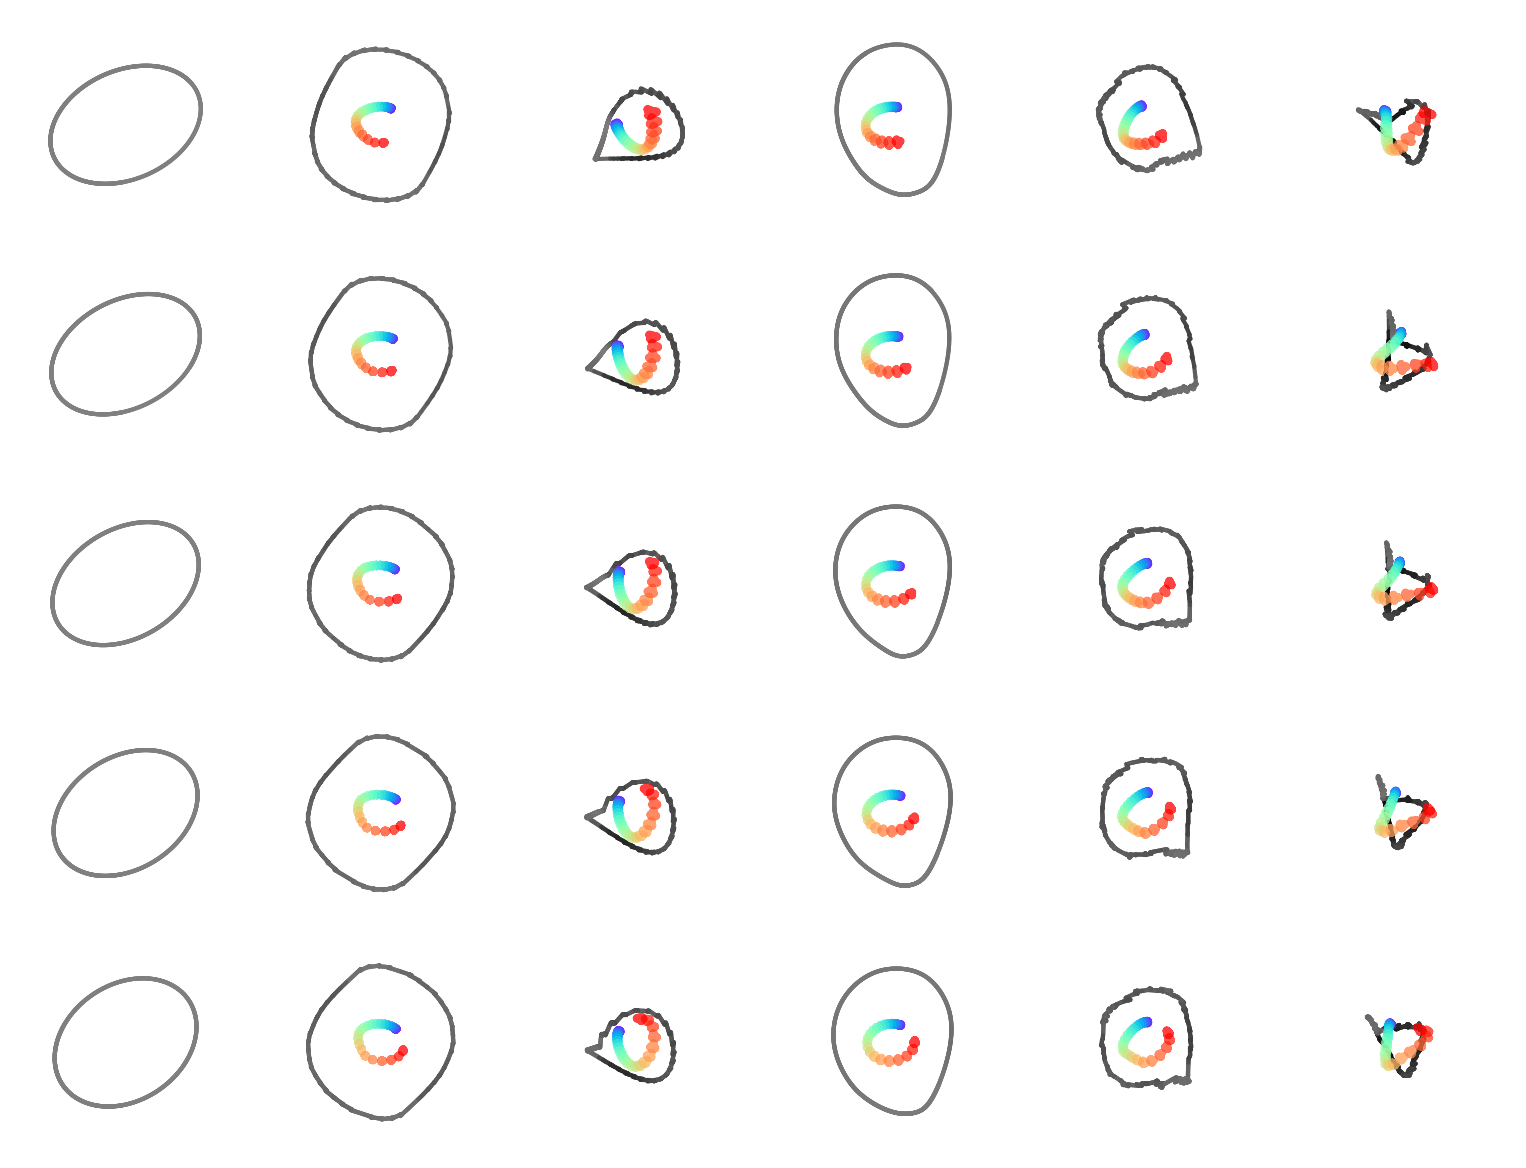

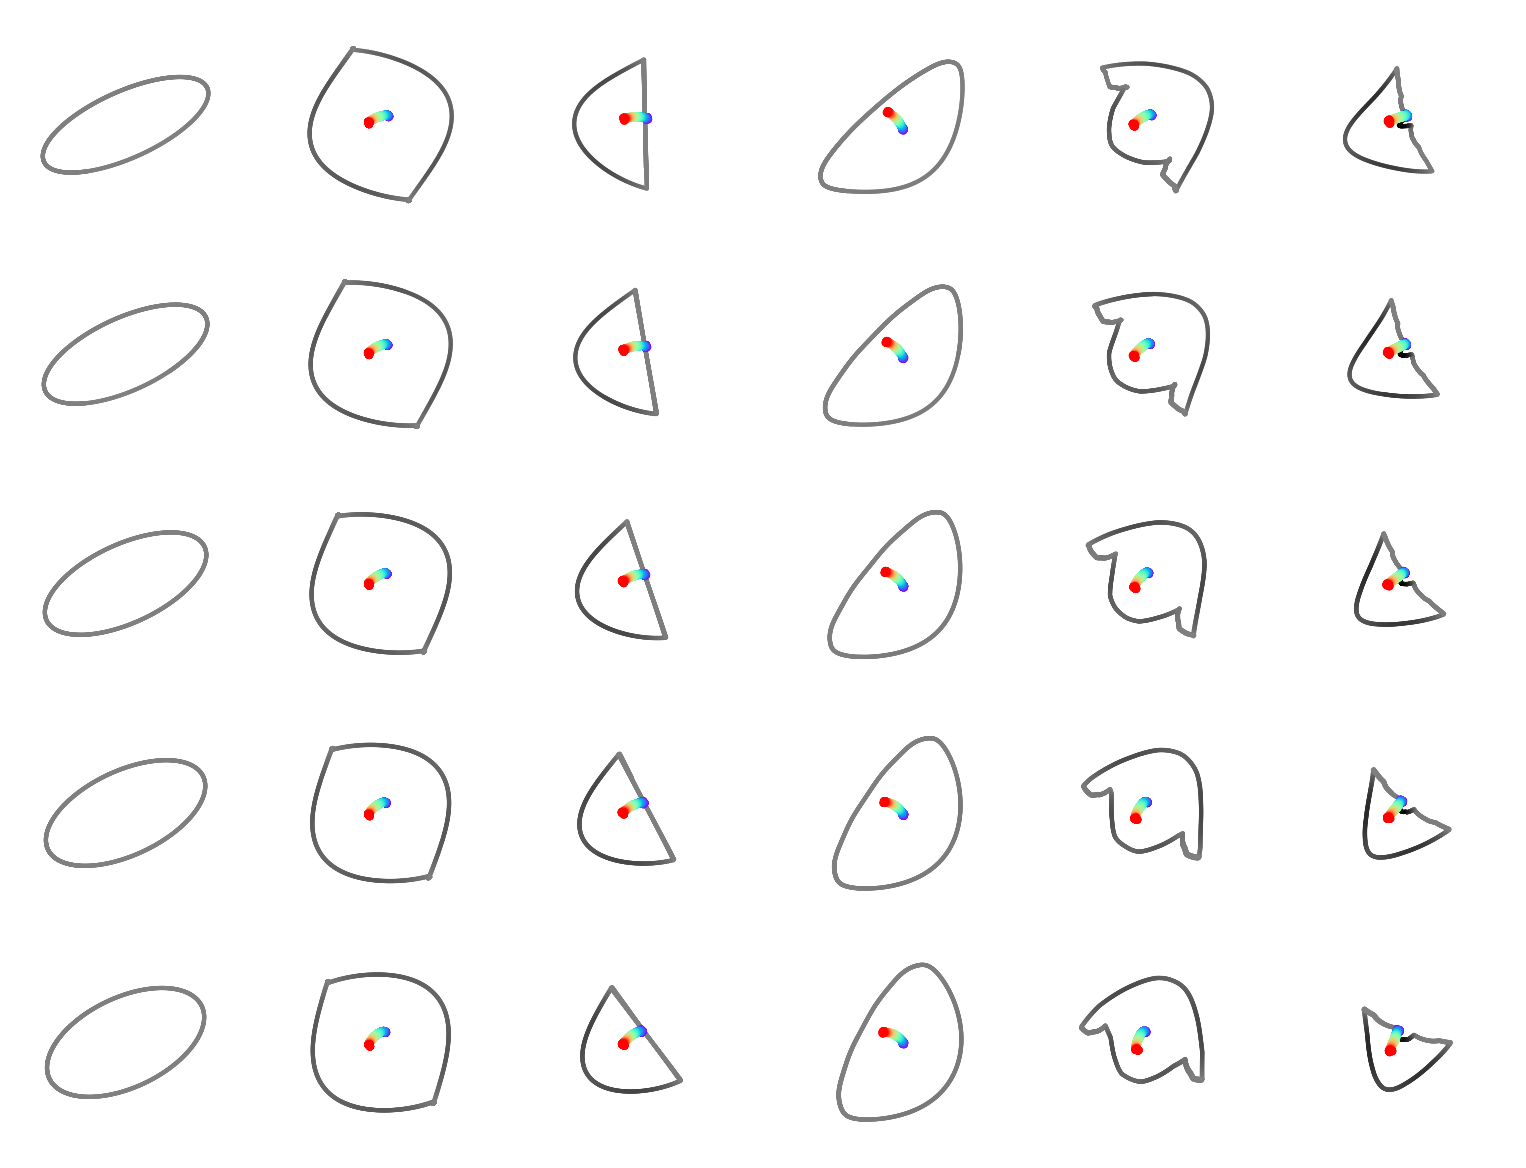

In [5]:
timbre_vs_frequency(collections, [0,800], '1.basic')
timbre_vs_frequency(collections, [0,491,797], '2.3d')
timbre_vs_frequency(collections, [0,191,307,491,797], '3.5d')
timbre_vs_frequency(collections, np.cumsum(range(12)), '4.12d')
timbre_vs_frequency(collections, np.cumsum(range(24)), '5.24d')
timbre_vs_frequency(collections, tuple(range(96)), '6.highd')

In [7]:
import wavio

In [18]:
# modify to point to your installation of OrchideaSOL
# (the directory given should be the one containing folders "Winds", "Strings", "PluckedStrings", etc.)

SOLPath = "/Users/amc/Downloads/OrchideaSOL2020/"

In [19]:
import os

# Initialize an empty dictionary to store the file paths
file_dict = {}

# Traverse the directory structure
for root, dirs, files in os.walk(SOLPath):
    for file in files:
        # Ignore .DS_Store files
        if file == ".DS_Store":
            continue
        
        # Split the filename to extract parameters
        parts = file.split('-')
        
        # Extract parameters
        instrument = parts[0]
        playing_style = parts[1]
        note = parts[2]
        dynamic = parts[3]
        
        # Create dictionary keys if they don't exist
        if instrument not in file_dict:
            file_dict[instrument] = {}
        if playing_style not in file_dict[instrument]:
            file_dict[instrument][playing_style] = {}
        if note not in file_dict[instrument][playing_style]:
            file_dict[instrument][playing_style][note] = {}
        if dynamic not in file_dict[instrument][playing_style][note]:
            file_dict[instrument][playing_style][note][dynamic] = []
        
        # Append file path to the dictionary
        file_dict[instrument][playing_style][note][dynamic].append(os.path.join(root, file))

In [26]:
file_dict['Fl']['ord']['A4']

{'pp': ['/Users/amc/Downloads/OrchideaSOL2020/Winds/Flute/ordinario/Fl-ord-A4-pp-N-T18u.wav'],
 'ff': ['/Users/amc/Downloads/OrchideaSOL2020/Winds/Flute/ordinario/Fl-ord-A4-ff-N-N.wav'],
 'mf': ['/Users/amc/Downloads/OrchideaSOL2020/Winds/Flute/ordinario/Fl-ord-A4-mf-N-N.wav']}

* Harmonic sum of sinusoids with varying coefficients


In [15]:
# Example usage
# Filter files by instrument, playing style, note, and dynamic
instrument_files = file_dict['Flute']
style_files = file_dict['Flute']['aeolian']
note_files = file_dict['Flute']['aeolian']['A4']
dynamic_files = file_dict['Flute']['aeolian']['A4']['pp']

# Print file paths for demonstration
print("Files for Flute - aeolian - A4 - pp:")
for file in dynamic_files:
    print(file)

Error: unknown format: 65534

In [16]:
np.cumsum(range(20))

array([  0,   1,   3,   6,  10,  15,  21,  28,  36,  45,  55,  66,  78,
        91, 105, 120, 136, 153, 171, 190])